Simulator...
x list [2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900]
Running sumo simulator
 Retrying in 1 seconds
Step #5400.00 (3ms ~= 83.33*RT, ~82000.00UPS, TraCI: 0ms, vehicles TOT 5999 ACT 246 BUF 0)tep #1125.00 (4ms ~= 62.50*RT, ~64250.00UPS, TraCI: 1ms, vehicles TOT 1081 ACT 257 BUF 0)ep #2250.00 (4ms ~= 62.50*RT, ~72500.00UPS, TraCI: 1ms, vehicles TOT 2425 ACT 290 BUF 0)p #3375.00 (5ms ~= 50.00*RT, ~59000.00UPS, TraCI: 0ms, vehicles TOT 3833 ACT 295 BUF 0) #4500.00 (4ms ~= 62.50*RT, ~62500.00UP

Step #5400.00 (6ms ~= 41.67*RT, ~72333.33UPS, TraCI: 0ms, vehicles TOT 7259 ACT 434 BUF 0)
x list [3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800]
Running sumo simulator
 Retrying in 1 seconds
ep #1125.00 (5ms ~= 50.00*RT, ~67800.00UPS, TraCI: 1ms, vehicles TOT 1363 ACT 339 BUF 0)ep #2250.00 (5ms ~= 50.00*RT, ~94400.00UPS, TraCI: 1ms, vehicles TOT 2988 ACT 472 BUF 0)p #3375.00 (6ms ~= 41.67*RT, ~107833.33UPS, TraCI: 1ms, vehicles TOT 4677 ACT 647 BUF 0

Step #5400.00 (5ms ~= 50.00*RT, ~86600.00UPS, TraCI: 0ms, vehicles TOT 7349 ACT 433 BUF 0)
MAIN modx [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Validator...
       *** USING local_exploration_validator_A
       *** USING get_fit_intervals:   [[1, 6.25]]


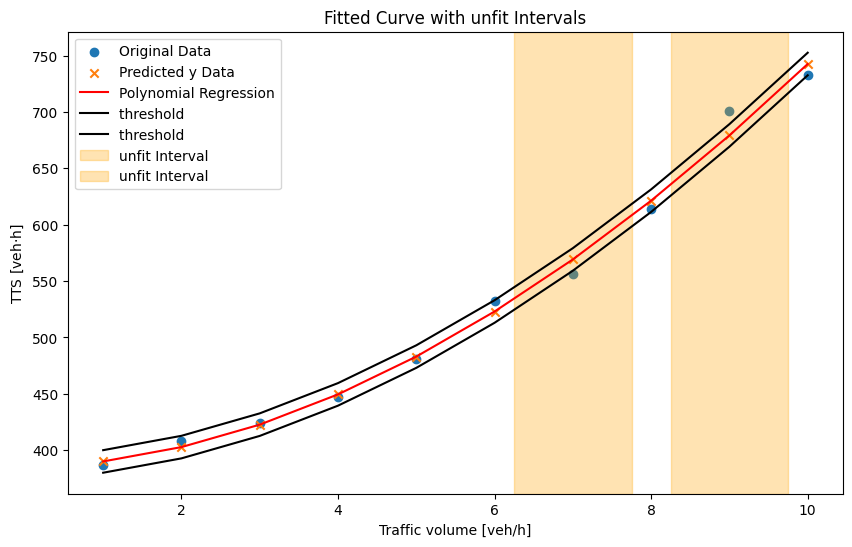

MAIN interval list from VAL: [[6.25, 7.75], [8.25, 9.75]]


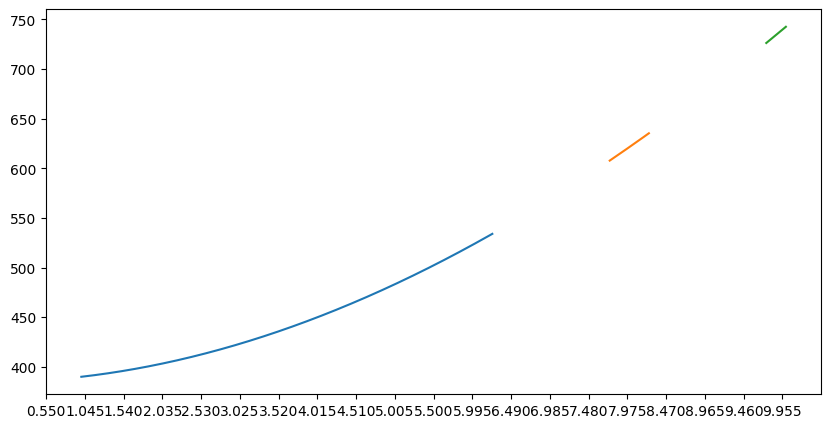

In [1]:
# IMPORT LIBRARIES
import numpy as np
import datetime

from components_configuration import components
from global_settings import simexSettings,mds

from validator_controller import ValidatorController
from modifier_controller import ModifierController
from simulator_controller import SimulatorController
from logger_utils import Logger

import pickle
import datetime
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
        

validator_controller_novsl = ValidatorController()
logger = Logger()
logger_main_arguments = {}
is_main_func = True

# SUMO vsl
from controller_modifier_scenarios import Controller

# SUMO vsl generate modifiers [[1,[2900,...2900],[2,[3000,...3000]....]
modlist = Controller.get_list_of_modifiers(10)
# print(f"Mod list: {modlist}")
# mod_x_list = modlist

# Calls Simulator
# Input: list of ids and modifiers [[1,[2900,...2900],[2,[3000,...3000]....]
# Output: IDs,SIMULATED(values) [[1,388.88],[2,420.22]]
mod_xnv,sim_y_listnv = SimulatorController.simulator(modlist,selected_simulator=components['sumo_simulator_novsl_old'])
assert len(mod_xnv) == len(sim_y_listnv)

print("MAIN modx", mod_xnv)

# Calls Validator controller
intervals_list_novsl =  validator_controller_novsl.validate(mod_x_list=np.array(mod_xnv),sim_y_list=np.array(sim_y_listnv), selected_validator=components['validator'],global_interval=[1, 10])
print("MAIN interval list from VAL:", intervals_list_novsl)

filename1 = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
save_object(validator_controller_novsl,f"vc_novsl-{filename1}.pkl")


# MAIN cycle completed/interrupted -> write OVERALL statistics        
logger_main_arguments['log_contex'] = 'Overall Stats'                          
logger_main_arguments['main_status'] = 'end cycle'
logger.log_main(logger_main_arguments)

Modifier...
[MODC]: intervals list:  [[2500, 4500]]
[MODC]: (interval_min_tick, interval_max_tick):  (2500, 4500)
[MODC]: mod_ticks:  [2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400]
[MODC]: mod_x:  [2600.0, 2675.714285714286, 2754.285714285714, 2835.714285714286, 2920.0, 3007.1428571428573, 3097.1428571428573, 3190.0, 3285.714285714286, 3384.285714285714, 3485.714285714286, 3590.0, 3697.142857142857, 3807.142857142857, 3920.0, 4035.714285714286, 4154.285714285714, 4275.714285714286, 4400.0]
MAIN mod outcome ([[2600.0, 2675.714285714286, 2754.285714285714, 2835.714285714286, 2920.0, 3007.1428571428573, 3097.1428571428573, 3190.0, 3285.714285714286, 3384.285714285714, 3485.714285714286, 3590.0, 3697.142857142857, 3807.142857142857, 3920.0, 4035.714285714286, 4154.285714285714, 4275.714285714286, 4400.0]], [[2500, 4500]])
Simulator...
[[2600.0, 2675.714285714286, 2754.285714285714, 2835.714285714286, 2920.0, 3007.142857142

Step #5400.00 (6ms ~= 41.67*RT, ~72166.67UPS, TraCI: 0ms, vehicles TOT 7259 ACT 433 BUF 0)
x list [3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142

Step #5400.00 (5ms ~= 50.00*RT, ~90200.00UPS, TraCI: 1ms, vehicles TOT 7349 ACT 451 BUF 0)
x list [3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0]
Running sumo simulator
 Retrying in 1 seconds
ep #1125.00 (5ms ~= 50.00*RT, ~72200.00UPS, TraCI: 1ms, vehicles TOT 1400 ACT 361 BUF 0)ep #2250.00 (6ms ~= 41.67*RT, ~79833.33UPS, Tra

Step #4575.00 (7ms ~= 35.71*RT, ~91857.14UPS, TraCI: 0ms, vehicles TOT 6490 ACT 643 BUF 0)

(7ms ~= 35.71*RT, ~89571.43UPS, TraCI: 0ms, vehicles TOT 6586 ACT 627 BUF 0)

Step #5400.00 (6ms ~= 41.67*RT, ~76333.33UPS, TraCI: 0ms, vehicles TOT 7529 ACT 458 BUF 0)
x list [4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714

Step #5400.00 (6ms ~= 41.67*RT, ~79000.00UPS, TraCI: 0ms, vehicles TOT 7709 ACT 474 BUF 0)
x list [4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285

Step #5400.00 (6ms ~= 41.67*RT, ~76666.67UPS, TraCI: 0ms, vehicles TOT 7889 ACT 460 BUF 0)
x list [4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714

Step #5400.00 (6ms ~= 41.67*RT, ~78666.67UPS, TraCI: 0ms, vehicles TOT 8069 ACT 472 BUF 0)
x list [4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0]
Running sumo simulator
 Retrying in 1 seconds
ep #1125.00 (6ms ~= 41.67*RT, ~75333.33UPS, TraCI: 1ms, vehicles TOT 1550 ACT 452 BUF 0)

Step #5400.00 (8ms ~= 31.25*RT, ~59750.00UPS, TraCI: 0ms, vehicles TOT 8249 ACT 478 BUF 0)
MODX [2600.0, 2675.714285714286, 2754.285714285714, 2835.714285714286, 2920.0, 3007.1428571428573, 3097.1428571428573, 3190.0, 3285.714285714286, 3384.285714285714, 3485.714285714286, 3590.0, 3697.142857142857, 3807.142857142857, 3920.0, 4035.714285714286, 4154.285714285714, 4275.714285714286, 4400.0] and sim_y_list [346.1388888888888, 361.98611111111103, 367.0416666666668, 378.5277777777778, 397.38888888888897, 409.5694444444444, 420.9166666666666, 440.16666666666646, 466.76388888888874, 515.6805555555555, 561.0277777777779, 602.8888888888887, 672.763888888889, 744.2916666666672, 762.4861111111111, 798.875, 829.6527777777779, 845.2222222222223, 880.4722222222222]
MAIN modx [2600.0, 2675.714285714286, 2754.285714285714, 2835.714285714286, 2920.0, 3007.1428571428573, 3097.1428571428573, 3190.0, 3285.714285714286, 3384.285714285714, 3485.714285714286, 3590.0, 3697.142857142857, 3807.142857142857, 3

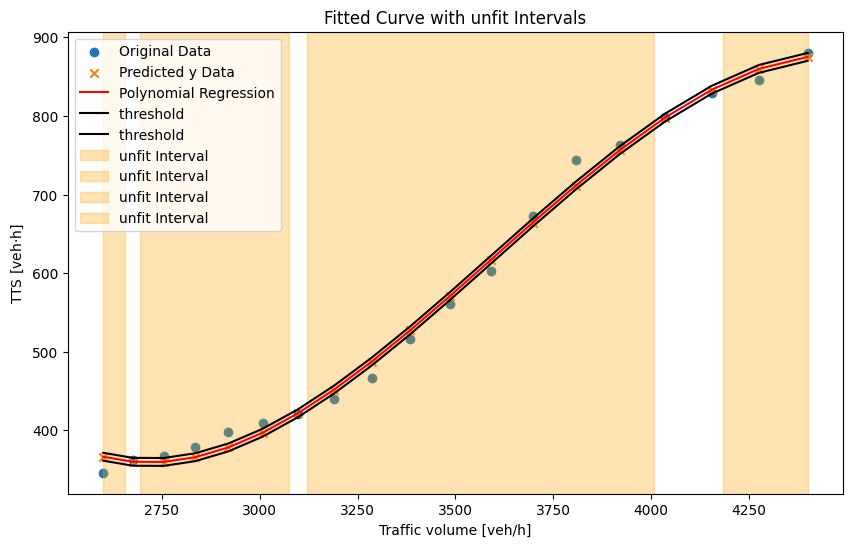

MAIN interval list from VAL: [[2600.0, 2656.785714285714], [2695.357142857143, 3074.6428571428573], [3120.357142857143, 4006.785714285714], [4184.642857142857, 4400.0]]
Modifier...
[MODC]: intervals list:  [[2600.0, 2656.785714285714], [2695.357142857143, 3074.6428571428573], [3120.357142857143, 4006.785714285714], [4184.642857142857, 4400.0]]
[MODC]: (interval_min_tick, interval_max_tick):  (2600.0, 2656.785714285714)
[MODC]: mod_ticks:  [2650]
[MODC]: mod_x:  [2650]
[MODC]: (interval_min_tick, interval_max_tick):  (2695.357142857143, 3074.6428571428573)
[MODC]: mod_ticks:  [2725, 2800, 2875, 2950, 3025]
[MODC]: mod_x:  [2725.0, 2797.0652173913045, 2871.086956521739, 2947.0652173913045, 3025.0]
[MODC]: (interval_min_tick, interval_max_tick):  (3120.357142857143, 4006.785714285714)
[MODC]: mod_ticks:  [3175, 3250, 3325, 3400, 3475, 3550, 3625, 3700, 3775, 3850, 3925, 4000]
[MODC]: mod_x:  [3175.0, 3242.1602787456445, 3310.8885017421603, 3381.184668989547, 3453.048780487805, 3526.480836

Step #5400.00 (6ms ~= 41.67*RT, ~70666.67UPS, TraCI: 0ms, vehicles TOT 7169 ACT 424 BUF 0)
x list [3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184

Step #5400.00 (6ms ~= 41.67*RT, ~74500.00UPS, TraCI: 0ms, vehicles TOT 7349 ACT 447 BUF 0)
x list [3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3

Step #4025.00 (7ms ~= 35.71*RT, ~105428.57UPS, TraCI: 1ms, vehicles TOT 5672 ACT 738 BUF 0

Step #4625.00 (7ms ~= 35.71*RT, ~86714.29UPS, TraCI: 0ms, vehicles TOT 6474 ACT 607 BUF 0)

Step #5400.00 (6ms ~= 41.67*RT, ~74333.33UPS, TraCI: 1ms, vehicles TOT 7439 ACT 446 BUF 0)
x list [3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3

Step #5400.00 (5ms ~= 50.00*RT, ~93800.00UPS, TraCI: 1ms, vehicles TOT 7529 ACT 469 BUF 0)
x list [4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0]
Running sumo simulator
 Retrying in 1 seconds
Step #2225.00 (6ms ~= 41.67*RT, ~87666.67UPS, TraCI: 0ms, vehicles TOT 3101 ACT 526 BUF 0)tep #1125.00 (5ms ~= 50.00*RT, ~75200.00UPS, 

Step #5400.00 (7ms ~= 35.71*RT, ~70571.43UPS, TraCI: 0ms, vehicles TOT 7709 ACT 494 BUF 0)
x list [4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0, 4225.0]
Running sumo simulator
 Retrying in 1 seconds
ep #1125.00 (5ms ~= 50.00*RT, ~86400.00UPS, TraCI: 1ms, vehicles TOT 1494 ACT 432 BUF 0)ep #2250.00 (7ms ~= 35.71*RT, ~90000.00UPS, Tra

Step #3600.00 (7ms ~= 35.71*RT, ~106285.71UPS, TraCI: 0ms, vehicles TOT 5392 ACT 744 BUF 0

Step #5400.00 (6ms ~= 41.67*RT, ~76333.33UPS, TraCI: 0ms, vehicles TOT 7979 ACT 458 BUF 0)
x list [4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345930232558, 4299.345

Step #5400.00 (5ms ~= 50.00*RT, ~92400.00UPS, TraCI: 1ms, vehicles TOT 8158 ACT 462 BUF 0)
x list [4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0]
Running sumo simulator
 Retrying in 1 seconds
Step #1100.00 (5ms ~= 50.00*RT, ~88000.00UPS, TraCI: 1ms, vehicles TOT 1512 ACT 440 BUF 0)

Step #5400.00 (6ms ~= 41.67*RT, ~79666.67UPS, TraCI: 1ms, vehicles TOT 8249 ACT 478 BUF 0)
MODX [2650, 2725.0, 2797.0652173913045, 2871.086956521739, 2947.0652173913045, 3025.0, 3175.0, 3242.1602787456445, 3310.8885017421603, 3381.184668989547, 3453.048780487805, 3526.480836236934, 3601.480836236934, 3678.048780487805, 3756.184668989547, 3835.8885017421603, 3917.1602787456445, 4000.0, 4225.0, 4299.345930232558, 4375.0] and sim_y_list [356.02777777777777, 359.5694444444444, 384.1388888888888, 387.2916666666666, 396.58333333333326, 403.458333333333, 440.6249999999999, 469.06944444444434, 469.2638888888889, 533.4027777777777, 540.513888888889, 602.736111111111, 631.277777777778, 690.1666666666667, 719.5972222222223, 745.9722222222221, 784.3749999999997, 794.9305555555558, 842.5416666666667, 869.8472222222224, 864.1527777777779]
MAIN modx [2650, 2725.0, 2797.0652173913045, 2871.086956521739, 2947.0652173913045, 3025.0, 3175.0, 3242.1602787456445, 3310.8885017421603, 3381.184668989547, 3453

/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)


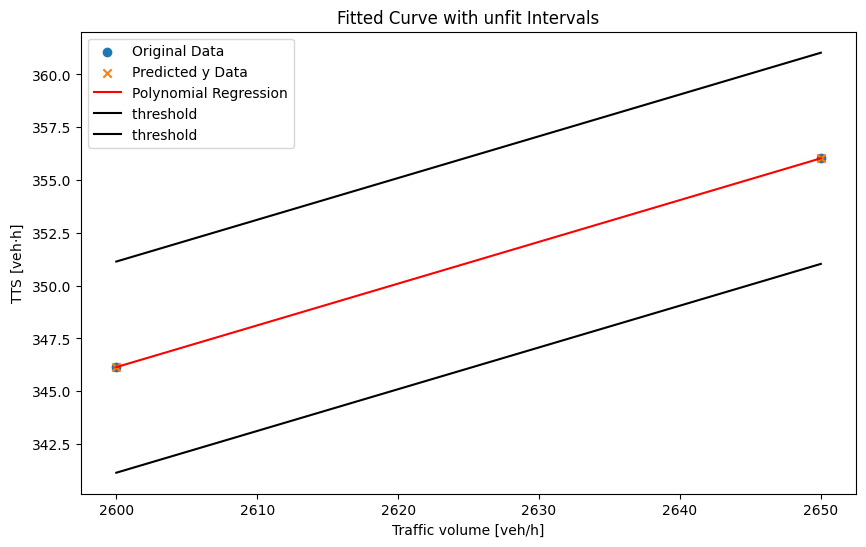

equation,
 y =  2.9178526499563515e-05x^2 + 0.044590513655071884x^1 + 32.956714248652645 
unfit_points
 [(2600.0, 346.1388888888888), (2650.0, 356.02777777777777)] 
local_unfit_interval
, [[2600.0, 2656.785714285714]]
       *** USING local_exploration_validator_A
       *** USING get_fit_intervals:   [[2695.357142857143, 2764.980590062112]]


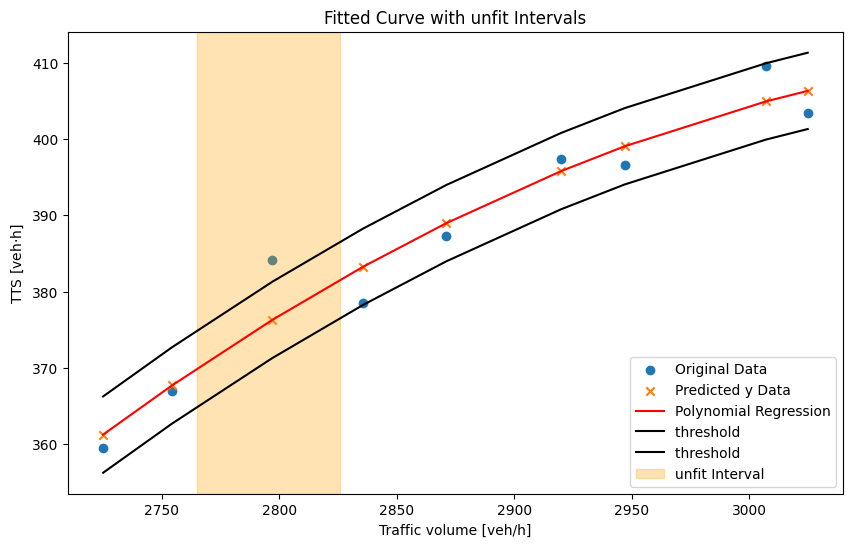

equation,
 y =  -0.0002564753847798716x^2 + 1.624834677672776x^1  -2161.911368780748 
unfit_points
 [(2725.0, 359.5694444444444), (2754.285714285714, 367.0416666666668), (2797.0652173913045, 384.1388888888888), (2835.714285714286, 378.5277777777778), (2871.086956521739, 387.2916666666666), (2920.0, 397.38888888888897), (2947.0652173913045, 396.58333333333326), (3007.1428571428573, 409.5694444444444), (3025.0, 403.458333333333)] 
local_unfit_interval
, [[2695.357142857143, 2764.980590062112], [2826.0520186335407, 3074.6428571428573]]
       *** USING local_exploration_validator_A
       *** USING get_fit_intervals:   [[3120.357142857143, 3175.0]]


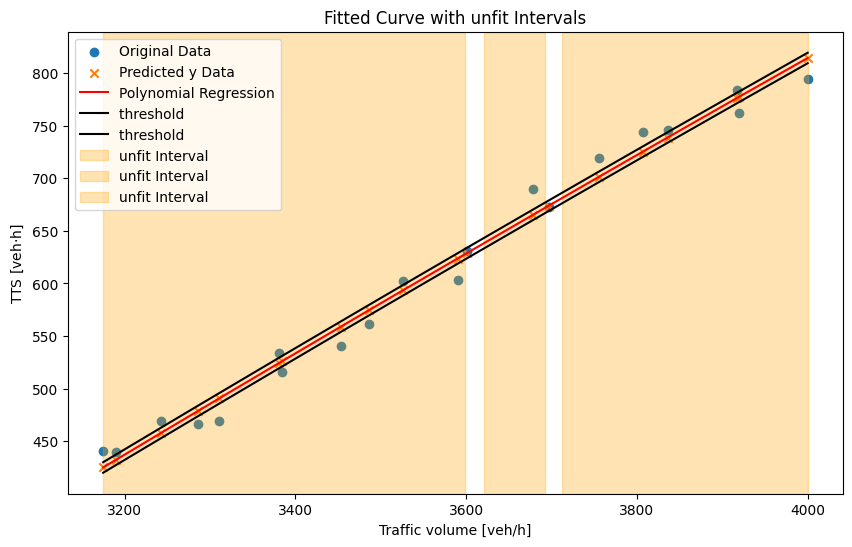

equation,
 y =  -1.6641892375756923e-05x^2 + 0.5914769489023551x^1  -1285.1791394565305 
unfit_points
 [(3175.0, 440.6249999999999), (3190.0, 440.16666666666646), (3242.1602787456445, 469.06944444444434), (3285.714285714286, 466.76388888888874), (3310.8885017421603, 469.2638888888889), (3381.184668989547, 533.4027777777777), (3384.285714285714, 515.6805555555555), (3453.048780487805, 540.513888888889), (3485.714285714286, 561.0277777777779), (3526.480836236934, 602.736111111111), (3590.0, 602.8888888888887), (3601.480836236934, 631.277777777778), (3678.048780487805, 690.1666666666667), (3697.142857142857, 672.763888888889), (3756.184668989547, 719.5972222222223), (3807.142857142857, 744.2916666666672), (3835.8885017421603, 745.9722222222221), (3917.1602787456445, 784.3749999999997), (3920.0, 762.4861111111111), (4000.0, 794.9305555555558)] 
local_unfit_interval
, [[3120.357142857143, 3175.0], [3598.6106271777007, 3620.6228222996515], [3692.369337979094, 3711.9033101045293], [4000.0, 40

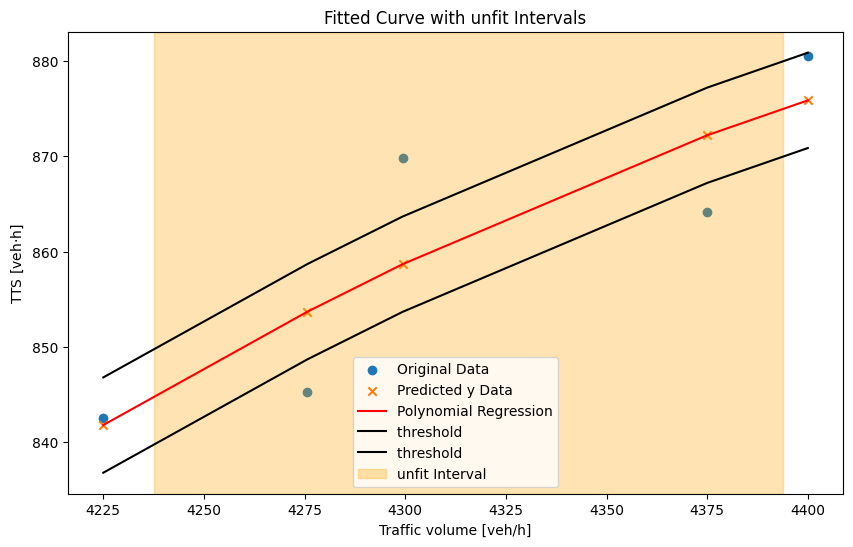

equation,
 y =  -0.00032143041384950365x^2 + 2.9669902427718595x^1  -5956.001218462506 
unfit_points
 [(4225.0, 842.5416666666667), (4275.714285714286, 845.2222222222223), (4299.345930232558, 869.8472222222224), (4375.0, 864.1527777777779), (4400.0, 880.4722222222222)] 
local_unfit_interval
, [[4184.642857142857, 4237.678571428572], [4393.75, 4400.0]]
DIFFERENCES 
each_interval  [4184.642857142857, 4400.0] 
new_unfit_interval   [[4237.678571428572, 4393.75]]
MAIN interval list from VAL: [[2764.980590062112, 2826.0520186335407], [3175.0, 3598.6106271777007], [3620.6228222996515, 3692.369337979094], [3711.9033101045293, 4000.0], [4237.678571428572, 4393.75]]
Modifier...
[MODC]: intervals list:  [[2764.980590062112, 2826.0520186335407], [3175.0, 3598.6106271777007], [3620.6228222996515, 3692.369337979094], [3711.9033101045293, 4000.0], [4237.678571428572, 4393.75]]
[MODC]: (interval_min_tick, interval_max_tick):  (2764.980590062112, 2826.0520186335407)
[MODC]: mod_ticks:  [2800]
[MODC]: m

Step #5400.00 (9ms ~= 27.78*RT, ~51111.11UPS, TraCI: 0ms, vehicles TOT 7349 ACT 460 BUF 0)
x list [3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025974025974, 3799.025

Step #5400.00 (10ms ~= 25.00*RT, ~44000.00UPS, TraCI: 1ms, vehicles TOT 7349 ACT 440 BUF 0
x list [3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3848.7012987012986, 3

Step #5400.00 (6ms ~= 41.67*RT, ~73166.67UPS, TraCI: 0ms, vehicles TOT 7439 ACT 439 BUF 0)
x list [3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025974025974, 3899.025

Step #5400.00 (7ms ~= 35.71*RT, ~64714.29UPS, TraCI: 0ms, vehicles TOT 7529 ACT 453 BUF 0)
x list [3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0]
Running sumo simulator
 Retrying in 1 seconds
ep #1125.00 (6ms ~= 41.67*RT, ~59833.33UPS, TraCI: 0ms, vehicles TOT 1419 ACT 359 BUF 0)ep #2250.00 (10ms ~= 25.00*RT, ~52000.00UPS, Tr

(8ms ~= 31.25*RT, ~79250.00UPS, TraCI: 0ms, vehicles TOT 6663 ACT 634 BUF 0)

Step #5400.00 (7ms ~= 35.71*RT, ~65857.14UPS, TraCI: 0ms, vehicles TOT 7619 ACT 461 BUF 0)
x list [4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0, 4250.0]
Running sumo simulator
 Retrying in 1 seconds
ep #1125.00 (7ms ~= 35.71*RT, ~58142.86UPS, TraCI: 0ms, vehicles TOT 1512 ACT 407 BUF 0)ep #2250.00 (10ms ~= 25.00*RT, ~65300.00UPS, Tr

Step #5400.00 (7ms ~= 35.71*RT, ~65428.57UPS, TraCI: 0ms, vehicles TOT 8069 ACT 458 BUF 0)
x list [4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709302325581, 4299.709

Step #5400.00 (7ms ~= 35.71*RT, ~66000.00UPS, TraCI: 0ms, vehicles TOT 8158 ACT 462 BUF 0)
x list [4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0]
Running sumo simulator
 Retrying in 1 seconds
ep #1125.00 (5ms ~= 50.00*RT, ~88200.00UPS, TraCI: 1ms, vehicles TOT 1550 ACT 441 BUF 0)

Step #5400.00 (21ms ~= 11.90*RT, ~22333.33UPS, TraCI: 1ms, vehicles TOT 8249 ACT 469 BUF 0
MODX [2800, 3200.0, 3247.777777777778, 3296.296296296296, 3345.5555555555557, 3395.5555555555557, 3446.2962962962965, 3497.777777777778, 3550.0, 3650, 3750.0, 3799.025974025974, 3848.7012987012986, 3899.025974025974, 3950.0, 4250.0, 4299.709302325581, 4350.0] and sim_y_list [377.5555555555555, 446.8888888888889, 468.7777777777777, 483.9166666666666, 494.8611111111112, 525.4722222222222, 532.1111111111111, 572.9027777777778, 621.0138888888891, 647.5416666666665, 717.3055555555559, 720.9583333333334, 758.4583333333329, 783.5277777777778, 786.291666666667, 855.8194444444445, 869.8472222222224, 873.9583333333335]
MAIN modx [2800, 3200.0, 3247.777777777778, 3296.296296296296, 3345.5555555555557, 3395.5555555555557, 3446.2962962962965, 3497.777777777778, 3550.0, 3650, 3750.0, 3799.025974025974, 3848.7012987012986, 3899.025974025974, 3950.0, 4250.0, 4299.709302325581, 4350.0]
Validator...
What are POINT

/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)


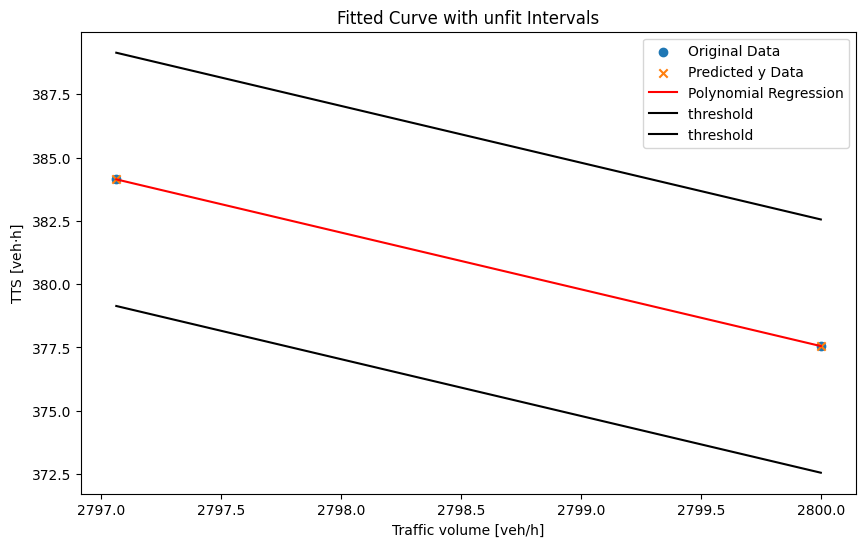

equation,
 y =  -0.00040888784925862255x^2 + 0.04536208235617116x^1 + 3456.222463145876 
unfit_points
 [(2797.0652173913045, 384.1388888888888), (2800.0, 377.5555555555555)] 
local_unfit_interval
, [[2764.980590062112, 2826.0520186335407]]
       *** USING local_exploration_validator_A
       *** USING get_fit_intervals:   [[3175.0, 3210.5400696864112]]


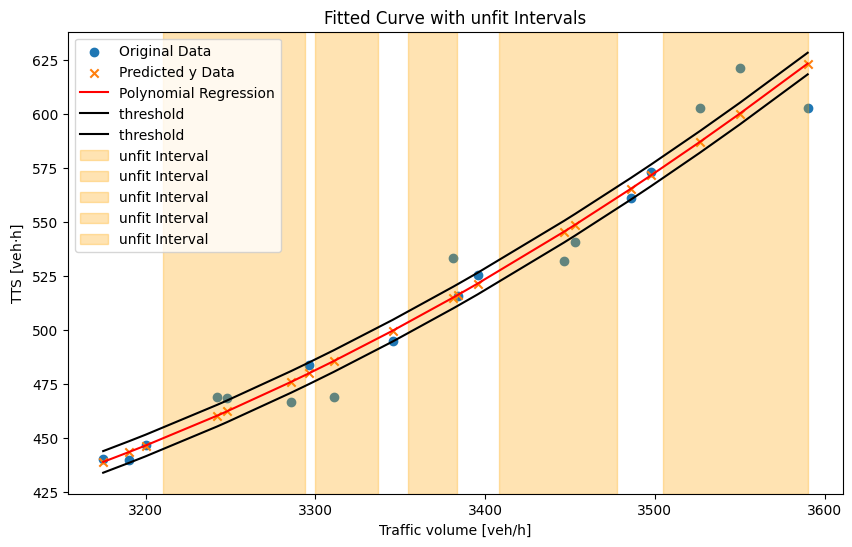

equation,
 y =  0.0003601779615493606x^2  -1.9928158689704456x^1 + 3135.4376440075853 
unfit_points
 [(3175.0, 440.6249999999999), (3190.0, 440.16666666666646), (3200.0, 446.8888888888889), (3242.1602787456445, 469.06944444444434), (3247.777777777778, 468.7777777777777), (3285.714285714286, 466.76388888888874), (3296.296296296296, 483.9166666666666), (3310.8885017421603, 469.2638888888889), (3345.5555555555557, 494.8611111111112), (3381.184668989547, 533.4027777777777), (3384.285714285714, 515.6805555555555), (3395.5555555555557, 525.4722222222222), (3446.2962962962965, 532.1111111111111), (3453.048780487805, 540.513888888889), (3485.714285714286, 561.0277777777779), (3497.777777777778, 572.9027777777778), (3526.480836236934, 602.736111111111), (3550.0, 621.0138888888891), (3590.0, 602.8888888888887)] 
local_unfit_interval
, [[3175.0, 3210.5400696864112], [3293.6507936507933, 3299.944347657762], [3336.888792102207, 3354.4628339140536], [3383.5104529616724, 3408.240740740741], [3477.547

/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)


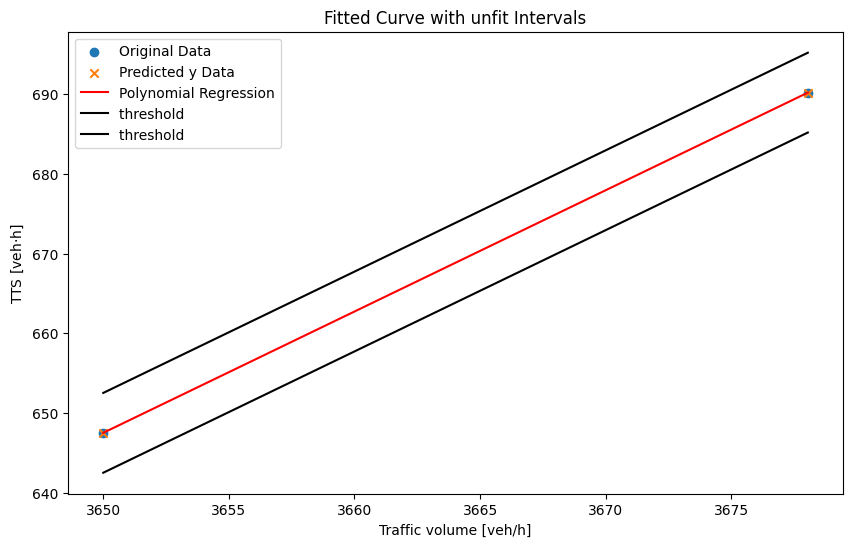

equation,
 y =  0.00019907140359631364x^2 + 0.06086895668950054x^1  -2226.758799661898 
unfit_points
 [(3650.0, 647.5416666666665), (3678.048780487805, 690.1666666666667)] 
local_unfit_interval
, [[3620.6228222996515, 3692.369337979094]]
       *** USING local_exploration_validator_A
       *** USING get_fit_intervals:   [[3711.9033101045293, 3766.8949952486537]]


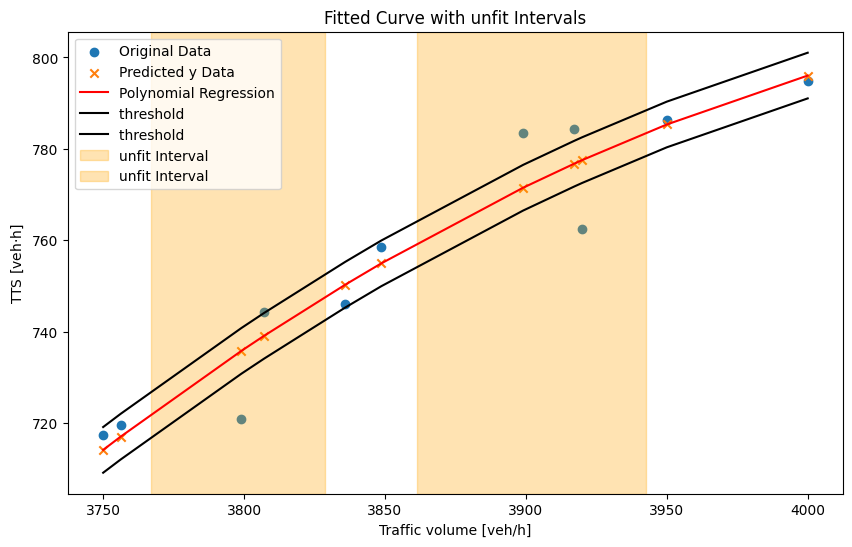

equation,
 y =  -0.0005679603764250363x^2 + 4.729460543509278x^1  -9034.443293910379 
unfit_points
 [(3750.0, 717.3055555555559), (3756.184668989547, 719.5972222222223), (3799.025974025974, 720.9583333333334), (3807.142857142857, 744.2916666666672), (3835.8885017421603, 745.9722222222221), (3848.7012987012986, 758.4583333333329), (3899.025974025974, 783.5277777777778), (3917.1602787456445, 784.3749999999997), (3920.0, 762.4861111111111), (3950.0, 786.291666666667), (4000.0, 794.9305555555558)] 
local_unfit_interval
, [[3711.9033101045293, 3766.8949952486537], [3828.7020905923346, 3861.2824675324673], [3942.5, 4000.0]]
       *** USING local_exploration_validator_A
       *** USING get_fit_intervals:   [[4237.678571428572, 4250.0]]


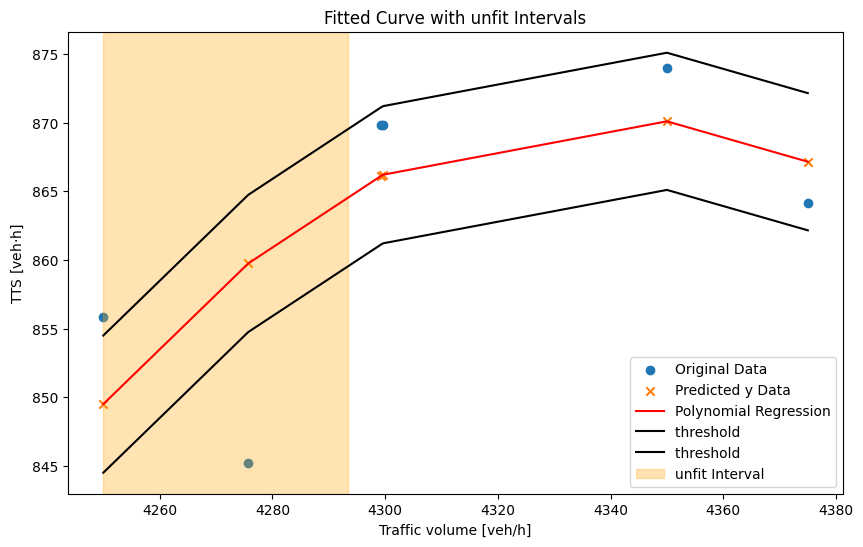

equation,
 y =  -0.0025918674579762137x^2 + 22.496202626338683x^1  -47943.76596155181 
unfit_points
 [(4250.0, 855.8194444444445), (4275.714285714286, 845.2222222222223), (4299.345930232558, 869.8472222222224), (4299.709302325581, 869.8472222222224), (4350.0, 873.9583333333335), (4375.0, 864.1527777777779)] 
local_unfit_interval
, [[4237.678571428572, 4250.0], [4293.43801910299, 4393.75]]
DIFFERENCES 
each_interval  [4237.678571428572, 4393.75] 
new_unfit_interval   [[4250.0, 4293.43801910299]]
MAIN interval list from VAL: [[3210.5400696864112, 3293.6507936507933], [3299.944347657762, 3336.888792102207], [3354.4628339140536, 3383.5104529616724], [3408.240740740741, 3477.5479094076654], [3504.9535423925668, 3590.0], [3766.8949952486537, 3828.7020905923346], [3861.2824675324673, 3942.5], [4250.0, 4293.43801910299]]
Modifier...
[MODC]: intervals list:  [[3210.5400696864112, 3293.6507936507933], [3299.944347657762, 3336.888792102207], [3354.4628339140536, 3383.5104529616724], [3408.2407407

Step #5400.00 (6ms ~= 41.67*RT, ~74500.00UPS, TraCI: 0ms, vehicles TOT 7349 ACT 447 BUF 0)
x list [3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3799.9177631578946, 3

Step #5400.00 (6ms ~= 41.67*RT, ~73333.33UPS, TraCI: 1ms, vehicles TOT 7349 ACT 440 BUF 0)
x list [3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0, 3825.0]
Running sumo simulator
 Retrying in 1 seconds
ep #1125.00 (5ms ~= 50.00*RT, ~70400.00UPS, TraCI: 1ms, vehicles TOT 1381 ACT 352 BUF 0)ep #2250.00 (6ms ~= 41.67*RT, ~82166.67UPS, Tra

Step #5400.00 (6ms ~= 41.67*RT, ~76000.00UPS, TraCI: 0ms, vehicles TOT 7439 ACT 456 BUF 0)
x list [3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0]
Running sumo simulator
 Retrying in 1 seconds
ep #1125.00 (8ms ~= 31.25*RT, ~44750.00UPS, TraCI: 0ms, vehicles TOT 1400 ACT 358 BUF 0)ep #2250.00 (6ms ~= 41.67*RT, ~82000.00UPS, Tra

Step #5400.00 (6ms ~= 41.67*RT, ~74166.67UPS, TraCI: 0ms, vehicles TOT 7529 ACT 445 BUF 0)
x list [3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3899.9198717948716, 3

Step #5400.00 (5ms ~= 50.00*RT, ~90600.00UPS, TraCI: 0ms, vehicles TOT 7529 ACT 453 BUF 0)
x list [3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0, 3925.0]
Running sumo simulator
 Retrying in 1 seconds
ep #1125.00 (5ms ~= 50.00*RT, ~69800.00UPS, TraCI: 0ms, vehicles TOT 1400 ACT 349 BUF 0)ep #2250.00 (7ms ~= 35.71*RT, ~68000.00UPS, Tra

Step #5400.00 (5ms ~= 50.00*RT, ~92400.00UPS, TraCI: 1ms, vehicles TOT 7529 ACT 462 BUF 0)
x list [4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275, 4275]
Running sumo simulator
 Retrying in 1 seconds
ep #1125.00 (6ms ~= 41.67*RT, ~68000.00UPS, TraCI: 1ms, vehicles TOT 1513 ACT 408 BUF 0)ep #2250.00 (10ms ~= 25.00*RT, ~62000.00UPS, TraCI: 1ms, vehicles TOT 3288 ACT 620 BUF 0

Step #5400.00 (7ms ~= 35.71*RT, ~67428.57UPS, TraCI: 0ms, vehicles TOT 8069 ACT 472 BUF 0)
MODX [3225.0, 3249.903846153846, 3275.0, 3300.0, 3325.0, 3375, 3425.0, 3449.909420289855, 3475.0, 3525.0, 3549.9119718309857, 3575.0, 3775.0, 3799.9177631578946, 3825.0, 3875.0, 3899.9198717948716, 3925.0, 4275] and sim_y_list [454.63888888888897, 446.1666666666668, 483.9305555555554, 481.0694444444444, 474.63888888888897, 490.9722222222224, 528.3194444444445, 556.3611111111113, 538.1111111111113, 567.375, 602.9166666666667, 634.7777777777776, 726.291666666667, 720.9583333333334, 754.902777777778, 758.5555555555555, 783.5277777777778, 752.2222222222225, 845.2222222222223]
MAIN modx [3225.0, 3249.903846153846, 3275.0, 3300.0, 3325.0, 3375, 3425.0, 3449.909420289855, 3475.0, 3525.0, 3549.9119718309857, 3575.0, 3775.0, 3799.9177631578946, 3825.0, 3875.0, 3899.9198717948716, 3925.0, 4275]
Validator...
What are POINTS  [[3225.0, 454.63888888888897], [3249.903846153846, 446.1666666666668], [3275.0, 483

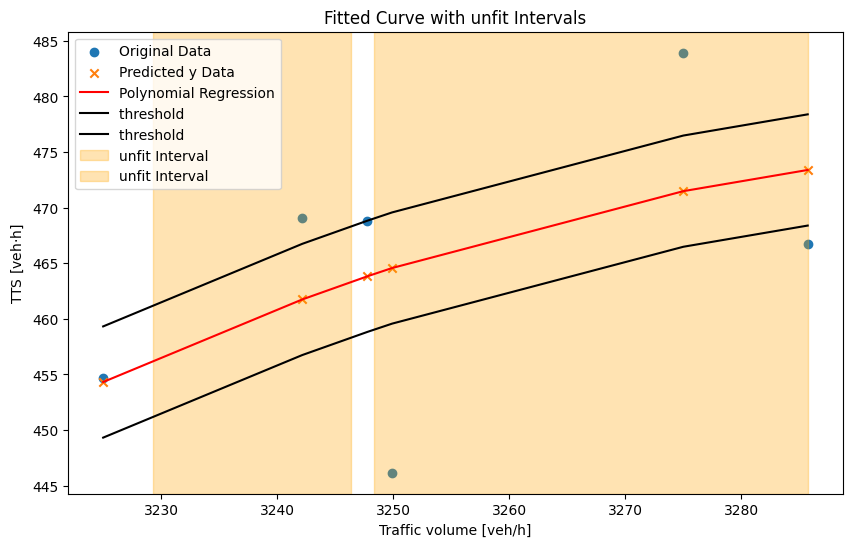

equation,
 y =  -0.0027244807045256605x^2 + 18.052357820047483x^1  -29428.22928659686 
unfit_points
 [(3225.0, 454.63888888888897), (3242.1602787456445, 469.06944444444434), (3247.777777777778, 468.7777777777777), (3249.903846153846, 446.1666666666668), (3275.0, 483.9305555555554), (3285.714285714286, 466.76388888888874)] 
local_unfit_interval
, [[3210.5400696864112, 3229.2900696864112], [3246.3734030197447, 3248.309294871795], [3285.714285714286, 3293.6507936507933]]
       *** USING local_exploration_validator_A


/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)


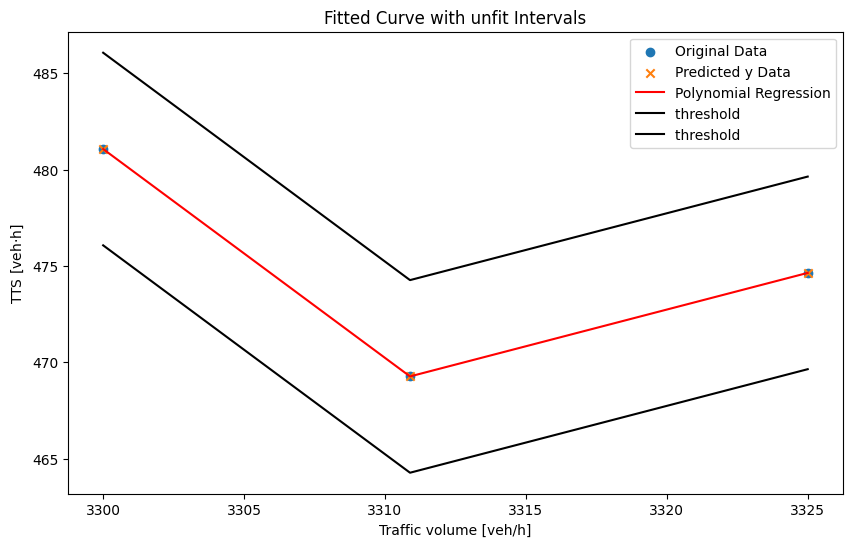

equation,
 y =  5.817221688847613e-17x^6  -2.4363497459964423e-16x^5  -3.8401033326831723e-10x^4  -1.6935606365602578e-06x^3  -0.004197912698119384x^2 + 0.07176212224077798x^1 + 77329.39687123282 
unfit_points
 [(3300.0, 481.0694444444444), (3310.8885017421603, 469.2638888888889), (3325.0, 474.63888888888897)] 
local_unfit_interval
, [[3299.944347657762, 3336.888792102207]]
       *** USING local_exploration_validator_A


/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)


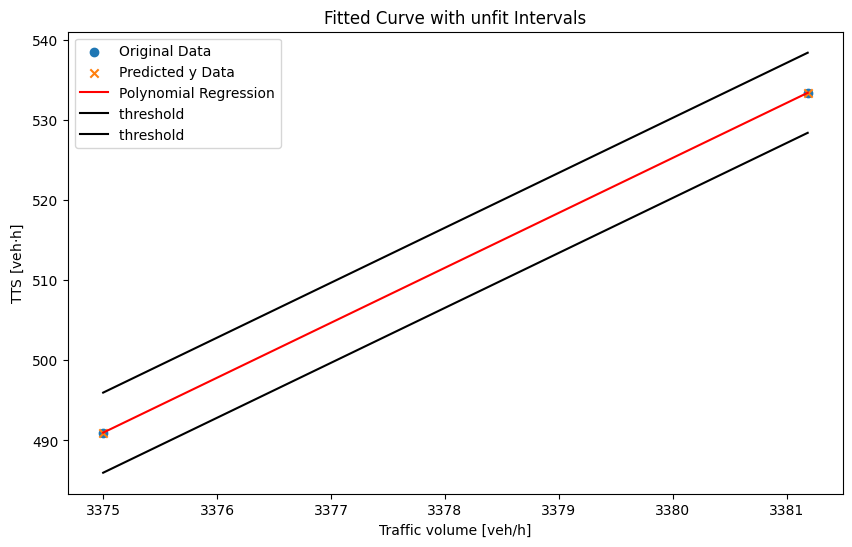

equation,
 y =  0.0010079737418195618x^2 + 0.050545762687020386x^1  -11161.070629759915 
unfit_points
 [(3375.0, 490.9722222222224), (3381.184668989547, 533.4027777777777)] 
local_unfit_interval
, [[3354.4628339140536, 3383.5104529616724]]
       *** USING local_exploration_validator_A
       *** USING get_fit_intervals:   [[3408.240740740741, 3430.324074074074]]


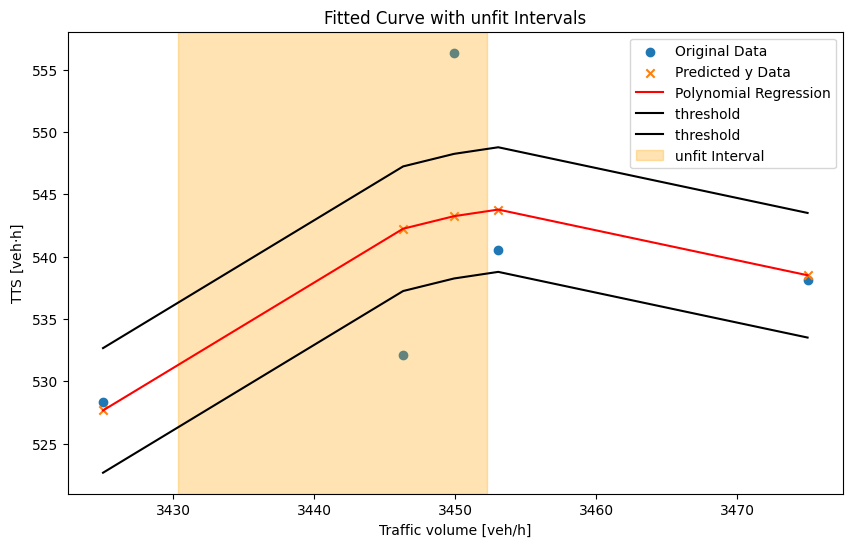

equation,
 y =  -0.01629523248263173x^2 + 112.65403863691354x^1  -194159.16416081818 
unfit_points
 [(3425.0, 528.3194444444445), (3446.2962962962965, 532.1111111111111), (3449.909420289855, 556.3611111111113), (3453.048780487805, 540.513888888889), (3475.0, 538.1111111111113)] 
local_unfit_interval
, [[3408.240740740741, 3430.324074074074], [3452.263940438317, 3477.5479094076654]]
       *** USING local_exploration_validator_A
       *** USING get_fit_intervals:   [[3504.9535423925668, 3525.0]]


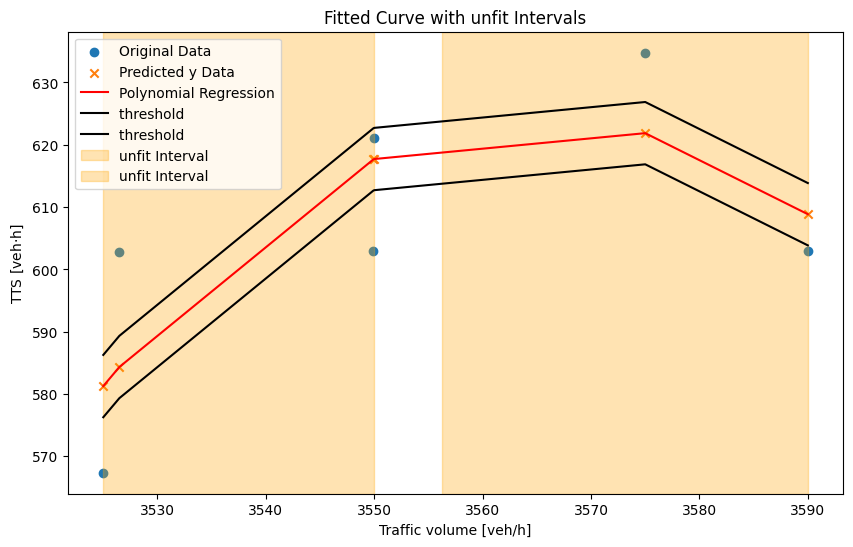

equation,
 y =  -0.025829701351165576x^2 + 184.20266876356607x^1  -327782.9455984178 
unfit_points
 [(3525.0, 567.375), (3526.480836236934, 602.736111111111), (3549.9119718309857, 602.9166666666667), (3550.0, 621.0138888888891), (3575.0, 634.7777777777776), (3590.0, 602.8888888888887)] 
local_unfit_interval
, [[3504.9535423925668, 3525.0], [3549.977992957746, 3556.25]]
       *** USING local_exploration_validator_A
       *** USING get_fit_intervals:   [[3766.8949952486537, 3781.0064935064934]]


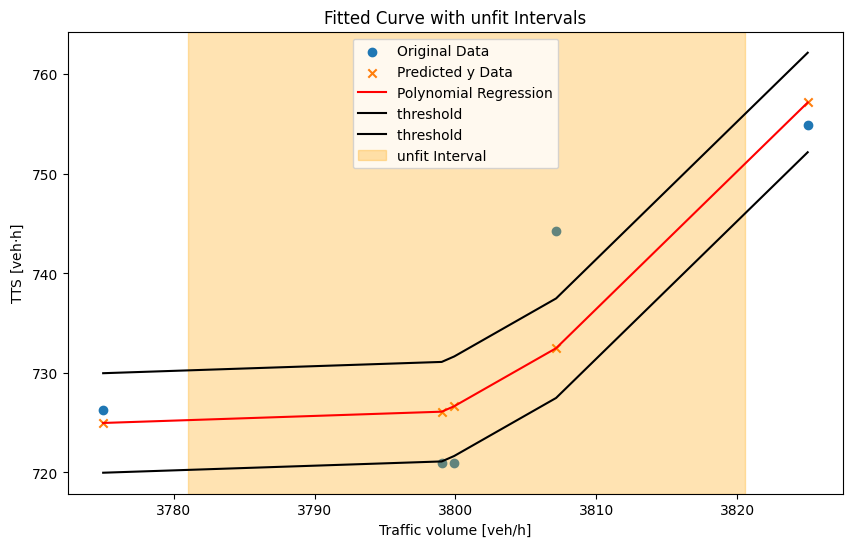

equation,
 y =  0.02298008791620815x^2  -174.00459550319397x^1 + 330111.706011729 
unfit_points
 [(3775.0, 726.291666666667), (3799.025974025974, 720.9583333333334), (3799.9177631578946, 720.9583333333334), (3807.142857142857, 744.2916666666672), (3825.0, 754.902777777778)] 
local_unfit_interval
, [[3766.8949952486537, 3781.0064935064934], [3820.535714285714, 3828.7020905923346]]
       *** USING local_exploration_validator_A
       *** USING get_fit_intervals:   [[3861.2824675324673, 3904.229973532565]]


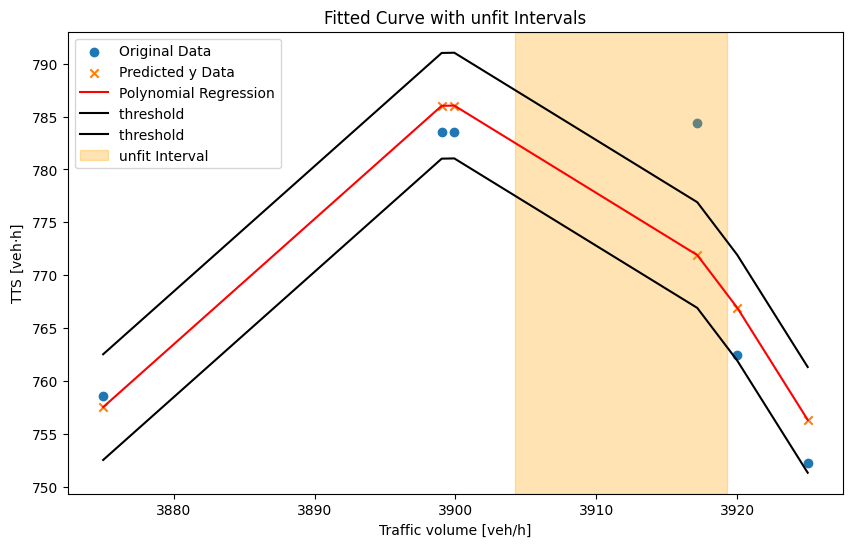

equation,
 y =  -0.046610898914806874x^2 + 363.5408622326106x^1  -708071.5494399877 
unfit_points
 [(3875.0, 758.5555555555555), (3899.025974025974, 783.5277777777778), (3899.9198717948716, 783.5277777777778), (3917.1602787456445, 784.3749999999997), (3920.0, 762.4861111111111), (3925.0, 752.2222222222225)] 
local_unfit_interval
, [[3861.2824675324673, 3904.229973532565], [3919.2900696864112, 3942.5]]
       *** USING local_exploration_validator_A


/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)


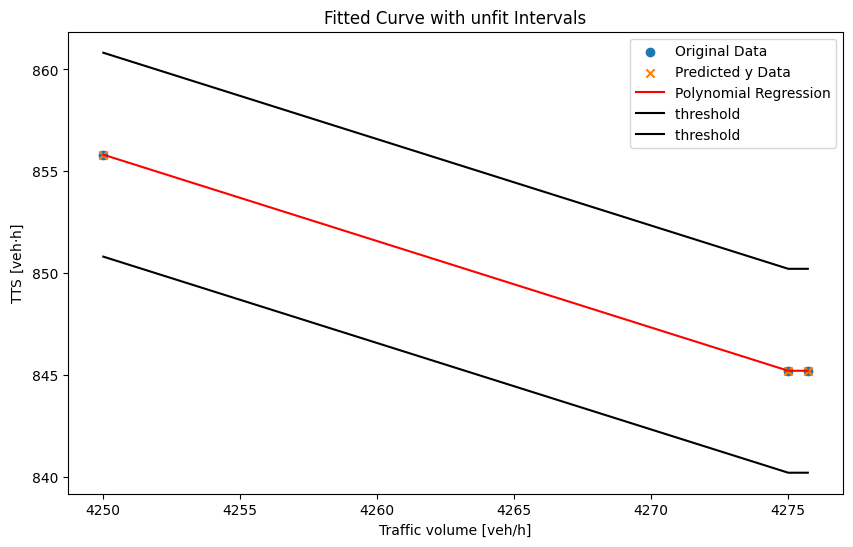

equation,
 y =  5.973929749869913e-18x^6  -9.949726379097548e-17x^5  -6.579858581197156e-11x^4  -3.726487908169109e-07x^3  -0.0011837345530743488x^2 + 0.09025193991862508x^1 + 36860.94175293543 
unfit_points
 [(4250.0, 855.8194444444445), (4275.0, 845.2222222222223), (4275.714285714286, 845.2222222222223)] 
local_unfit_interval
, [[4250.0, 4293.43801910299]]
DIFFERENCES 
each_interval  [4250.0, 4293.43801910299] 
new_unfit_interval   []
MAIN interval list from VAL: [[3229.2900696864112, 3246.3734030197447], [3248.309294871795, 3285.714285714286], [3430.324074074074, 3452.263940438317], [3525.0, 3549.977992957746], [3556.25, 3590.0], [3781.0064935064934, 3820.535714285714], [3904.229973532565, 3919.2900696864112]]
Modifier...
[MODC]: intervals list:  [[3229.2900696864112, 3246.3734030197447], [3248.309294871795, 3285.714285714286], [3430.324074074074, 3452.263940438317], [3525.0, 3549.977992957746], [3556.25, 3590.0], [3781.0064935064934, 3820.535714285714], [3904.229973532565, 3919.290

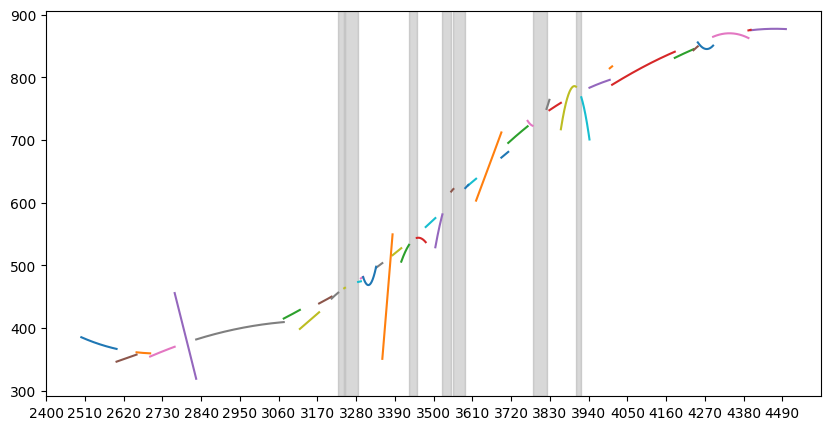

In [1]:
# IMPORT LIBRARIES
import numpy as np

from components_configuration import components
from global_settings import simexSettings,mds

from validator_controller import ValidatorController
from modifier_controller import ModifierController
from simulator_controller import SimulatorController
from logger_utils import Logger

import pickle
import datetime
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

validator_controller_novsl = ValidatorController()
logger = Logger()
logger_main_arguments = {}
is_main_func = True
# Initialize interval list for the first iteration
intervals_list=[[mds['domain_min_interval'], mds['domain_max_interval']]]
#intervals_list=[[2900, 3200]]
# Values for the timestamp of the pickle file
count = 0
filename1 = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

while is_main_func:
    
    # Calls Modifier Controller
    mod_outcome = ModifierController.control(intervals_list=intervals_list,selected_modifier=components['modifierA'], do_plot=simexSettings['do_plot'])
    mod_x_list = mod_outcome[0]
    checked_intervals = mod_outcome[1]
    print("MAIN mod outcome", mod_outcome)  

    
    # breaks loop if iterations end by granularity reached
    if not mod_x_list: # FALSE IF ['modifier_data_point'] < mdv['modifier_incremental_unit']:
        logger_main_arguments['log_contex'] = 'overall MAIN stats'
        logger_main_arguments['main_status'] = 'no generated points'
        logger_main_arguments['remaining_unfit_intervals'] = checked_intervals
        logger.log_main(logger_main_arguments)
        break
    
    # Calls Simulator
    mod_x,sim_y_list = SimulatorController.simulate(mod_x_list,selected_simulator=components['sumo_simulator_novsl'])
    print(f"MODX {mod_x} and sim_y_list {sim_y_list}")
    assert len(mod_x) == len(sim_y_list)

    print("MAIN modx", mod_x)  

    # Calls Validator controller
    intervals_list =  validator_controller_novsl.validate(mod_x_list=np.array(mod_x),sim_y_list=np.array(sim_y_list), selected_validator=components['validator'],global_interval=[mds["domain_min_interval"], mds["domain_max_interval"]])
    print("MAIN interval list from VAL:", intervals_list)
    # Loop number (loop-1,loop2..etc)
    count +=1
    save_object(validator_controller_novsl,f"vc_novsl_loop-{count}-{filename1}.pkl")
    
    # Updates interval_list to new range output from validator controller
    # No more unfit intervals -> write MAIN log
    if not intervals_list:
        is_main_func = False
        logger_main_arguments['log_contex'] = 'overall MAIN stats'
        logger_main_arguments['main_status'] = 'no unfit intervals'
        logger.log_main(logger_main_arguments)

# MAIN cycle completed/interrupted -> write OVERALL statistics        
logger_main_arguments['log_contex'] = 'Overall Stats'                          
logger_main_arguments['main_status'] = 'end cycle'
logger.log_main(logger_main_arguments)
